# Sentiment Classification

In [123]:
import re
import numpy as np
import scipy.interpolate as interp
import matplotlib.pyplot as plt

from glob import glob
from random import shuffle
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.decomposition import LatentDirichletAllocation, MiniBatchSparsePCA

In [201]:
ENGLISH_STOP_WORDS = frozenset([
    "a", "about", "above", "across", "after", "afterwards", "again", "against",
    "all", "almost", "alone", "along", "already", "also", "although", "always",
    "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
    "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are",
    "around", "as", "at", "back", "be", "became", "because", "become",
    "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
    "below", "beside", "besides", "between", "beyond", "bill", "both",
    "bottom", "but", "by", "call", "can", "cannot", "cant", "co", "con",
    "could", "couldnt", "cry", "de", "describe", "detail", "do", "done",
    "down", "due", "during", "each", "eg", "eight", "either", "eleven", "else",
    "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
    "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill",
    "find", "fire", "first", "five", "for", "former", "formerly", "forty",
    "found", "four", "from", "front", "full", "further", "get", "give", "go",
    "had", "has", "hasnt", "have", "he", "hence", "her", "here", "hereafter",
    "hereby", "herein", "hereupon", "hers", "herself", "him", "himself", "his",
    "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed",
    "interest", "into", "is", "it", "its", "itself", "keep", "last", "latter",
    "latterly", "least", "less", "ltd", "made", "many", "may", "me",
    "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly",
    "move", "much", "must", "my", "myself", "name", "namely", "neither",
    "never", "nevertheless", "next", "nine", "no", "nobody", "none", "noone",
    "nor", "not", "nothing", "now", "nowhere", "of", "off", "often", "on",
    "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our",
    "ours", "ourselves", "out", "over", "own", "part", "per", "perhaps",
    "please", "put", "rather", "re", "same", "see", "seem", "seemed",
    "seeming", "seems", "serious", "several", "she", "should", "show", "side",
    "since", "sincere", "six", "sixty", "so", "some", "somehow", "someone",
    "something", "sometime", "sometimes", "somewhere", "still", "such",
    "system", "take", "ten", "than", "that", "the", "their", "them",
    "themselves", "then", "thence", "there", "thereafter", "thereby",
    "therefore", "therein", "thereupon", "these", "they", "thick", "thin",
    "third", "this", "those", "though", "three", "through", "throughout",
    "thru", "thus", "to", "together", "too", "top", "toward", "towards",
    "twelve", "twenty", "two", "un", "under", "until", "up", "upon", "us",
    "very", "via", "was", "we", "well", "were", "what", "whatever", "when",
    "whence", "whenever", "where", "whereafter", "whereas", "whereby",
    "wherein", "whereupon", "wherever", "whether", "which", "while", "whither",
    "who", "whoever", "whole", "whom", "whose", "why", "will", "with",
    "within", "without", "would", "yet", "you", "your", "yours", "yourself",
    "yourselves"])

In [202]:
positives_path = glob("movies1000/pos/*")
negatives_path = glob("movies1000/neg/*")

In [208]:
def read_train_file(path):
    f = open(path)
    txt = f.read()
    f.close()
    return txt

positives_txt = list(map(read_train_file, positives_path))
negatives_txt = list(map(read_train_file, negatives_path))

In [209]:
positives_txt[0][:100]

"films adapted from comic books have had plenty of success , whether they're about superheroes ( batm"

In [210]:
f = open("testSentiment.txt")
submission_txt = f.readlines()
f.close()

submission_txt[0]

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.\n"

In [211]:
(
    np.array(list(map(len, positives_txt))).mean(), 
    np.array(list(map(len, negatives_txt))).mean(), 
    np.array(list(map(len, submission_txt))).mean(), 
)

(4124.283, 3661.721, 1326.06964)

In [212]:
def preprocessing(txt): #TODO: find a way to merge names
    #txt = txt.lower()
    txt = txt.replace(' /', '/').replace('/ ', '/')
    txt = txt.replace('_', ' ')              #not after because of the created words...
    txt = txt.replace('<br/>', ' ')
    txt = txt.replace('it\'s', 'it is')
    txt = txt.replace('n\'t', ' not') 
    txt = txt.replace('\'ll', ' will_future')
    txt = txt.replace('not ', 'not_') #make negation becaming bigrams
    txt = txt.replace(' th ', 'th ') #for numbers
    for w in ENGLISH_STOP_WORDS: #remove all stopwords
        txt = txt.replace(' ' + w + ' ', ' ')
    for e in re.findall(r'\.\.+', txt): #elipsis
        txt.replace(e, '_ELISPSIS_')
    #detect all notes and make them on 10
    for p in re.findall(r'\d*[.,]*\d*%', txt): #get all percentages
        if p != '%':
            txt = txt.replace(
                p, 
                ' ' + str(int(float(p[:-1].replace(',', '.')) / 10)) + '_NOTE '
            )
    for n in re.findall(r'\d+ out of \d+', txt): #get all marks
        a, b = n.split(' out of ')
        a, b = float(a), float(b)
        txt = txt.replace(n, ' ' + str(int((a / b) * 10)) + '_NOTE ')
    for n in re.findall(r'\d+[.,]*\d*/\d+[.,]*\d*', txt):
        try:
            a, b = n.split('/')
            a, b = float(a.replace(',', '.')), float(b)
            txt = txt.replace(n, ' ' + str(int(a / b)) + '_NOTE ')
        except:
            print(n)
    for n in re.findall(r'\d+[.,]*\d*/10', txt):#re.findall(r'\d+[.,]*\d*/\d+[.,]*\d*', txt):
        try:
            a, b = n.split('/')
            a, b = float(a.replace(',', '.')), float(b)
            txt = txt.replace(n, ' ' + str(int(a / b)) + '_NOTE ')
        except:
            print(n)
    #for r in re.findall(r'rating\sof\s\d+[.,]*\d*', txt):   
    for n_0 in re.findall("\ 0+", txt): #sert a rien
        txt = txt.replace(n_0, ' ')
    for n in re.findall(" \d+s ", txt):
        txt = txt.replace(n, ' ' + n[1:-2] + ' ')
    return txt

preprocessing(positives_txt[0])

'films adapted comic books plenty success , they\'re superheroes ( batman , superman , spawn ) , geared kids ( casper ) arthouse crowd ( ghost world ) , there\'s really comic book like hell . \nfor starters , created alan moore ( eddie campbell ) , brought medium new level mid \'80s 12-part series called watchmen . \nto say moore campbell thoroughly researched subject jack ripper like saying michael jackson starting look little odd . \nthe book ( " graphic novel , " ) 500 pages long includes nearly 30 consist footnotes . \nin words , not_dismiss film source . \nif past comic book thing , stumbling block hell\'s directors , albert allen hughes . \ngetting hughes brothers direct ludicrous casting carrot , , , riddle : better direct film that\'s set ghetto features really violent street crime mad geniuses menace ii society ? \nthe ghetto question , course , whitechapel 1888 london\'s east end . \nit filthy , sooty place whores ( called " unfortunates " ) starting little nervous mysterious

In [213]:
positives_txt = list(map(preprocessing, positives_txt))
negatives_txt = list(map(preprocessing, negatives_txt))
submission_txt = list(map(preprocessing, submission_txt))

10/10,
1/10,
2/10,
10/10,
8/10....
10/10,
2/10,
9/11,
9/11,
9/11,
9/11,
9/11,
9/11,
9/11,
9/11,
8/10,
1/10,
3/10,
10/10,
10/10,
3/10,
9/10,
3/10,
6/10,
0/10...
1/10.......
6/10,
4/10,
3/10,
10/10,
10/10,
8/10,
4/10,
7/10,
1/2007,
2.5/5...
4.0/10,
1/2...
1/2,
1950/51,
1/10.......
9/10...
9/10,
10/10...
1/10,
1/10,
2/10,
10/10,
9/11,
3/10,
1/2...
10/10...
1.5/10,
7/10,
10/10..
7/10,
2/10,
7/10,
3/10,
10/10,
8/10,
10/10,
4/10,
9/11,
4/10...
10/10,
3/10,
10/10,
10/10,
1/5,
2/10,
0/0
9/10,
3/10,
3/10,
5/10,
4/10,
8/10...
7/10....
2/10,
3/10,
2/5,
0/10..
1/2,
0/1,000
8/10,
9/11,
9/11,
9/11,
8.5/10,
7.5/10,
8.5/10,
8/10,
24/7,
1/10,


In [214]:
count_vect = CountVectorizer()#ngram_range=(1, 2))#, max_features=100000) #work bettern without bigrams
submission_txt_counts = count_vect.fit_transform(submission_txt) #only use words which are present in the final testing set
positives_txt_count = count_vect.transform(positives_txt)
negatives_txt_count = count_vect.transform(negatives_txt)

In [215]:
# TF-IDF encoding
tfidf_transformer = TfidfTransformer()
submission_txt_tfidf = tfidf_transformer.fit_transform(submission_txt_counts)
positives_txt_tfidf = tfidf_transformer.transform(positives_txt_count)
negatives_txt_tfidf = tfidf_transformer.transform(negatives_txt_count)

/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [216]:
shuffle(list(positives_txt_tfidf))
shuffle(list(negatives_txt_tfidf))

In [217]:
x_train_txt = list(positives_txt[:800]) + list(negatives_txt[:800])
x_test_txt  = list(positives_txt[800:]) + list(negatives_txt[800:])

x_train = list(positives_txt_tfidf[:800]) + list(negatives_txt_tfidf[:800])
x_test  = list(positives_txt_tfidf[800:]) + list(negatives_txt_tfidf[800:])

In [218]:
training_data = list(zip(x_train, [1] * 800 + [0] * 800, x_train_txt))
testing_data  = list(zip(x_test,  [1] * 200 + [0] * 200, x_test_txt))

In [219]:
shuffle(training_data)
shuffle(testing_data)

In [220]:
x_train, y_train, x_train_txt = zip(*training_data)
x_test,  y_test,  x_test_txt  = zip(*testing_data)

In [221]:
x_train = np.array(list(map(lambda L: L.toarray()[0], x_train)))
x_test  = np.array(list(map(lambda L: L.toarray()[0], x_test)))

In [151]:
#just few cehcks
np.array(y_train).mean(), len(set(positives_txt_tfidf.toarray()[5]))

(0.5, 282)

In [141]:
#check there is no a simple threshold way to separe positives from negatives
positives_txt_tfidf.toarray().mean(1).std(), negatives_txt_tfidf.toarray().mean(1).std()

(3.1272244955168496e-05, 3.0034728102255493e-05)

## Simple try on TF-IDF vectors

In [226]:
logistic_clf = LinearSVC(C=1)#0)#C#CalibratedClassifierCV(LinearSVC(C=1.5)) #LinearSVC()
logistic_clf.fit(x_train, y_train)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [227]:
(logistic_clf.predict(x_test) == y_test).mean() #a lower accuracy can get a better accuracy on the real leader board...

0.8725

In [142]:
for i in range(10):
    print(i, end=' ')
    print(logistic_clf.coef_[0, count_vect.get_feature_names().index('{}_note'.format(i))])
#strangely notes values are reversed... FIXME ?

0 0.6574546323901839
1 -0.0676238328271007
2 -0.07961109472081579
3 0.01934811469797378
4 0.0
5 -0.029520565566614972
6 -0.06764169068505052
7 -0.004704048860954397
8 -0.04183636820155538
9 -0.08298789739326498


In [119]:
forest_clf = RandomForestClassifier(2000, n_jobs=-1)
forest_clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [120]:
(forest_clf.predict(x_test) == y_test).mean()

0.8025

In [143]:
bayes_clf = MultinomialNB(alpha=.7)
bayes_clf.fit(x_train, y_train)

MultinomialNB(alpha=0.7, class_prior=None, fit_prior=True)

In [144]:
(bayes_clf.predict(x_test) == y_test).mean()

0.8

In [64]:
#voting classifier
((
    #  (bayes_clf.predict_proba(x_test) * .8)  #seem to work better without bayes
    + (forest_clf.predict_proba(x_test) * .8075) 
    + (logistic_clf.predict_proba(x_test) * .8775)
).argmax(1) == y_test).mean()

AttributeError: 'LinearSVC' object has no attribute 'predict_proba'

In [69]:
bag_clf = BaggingClassifier(
    base_estimator=LogisticRegression(C=1.5),#CalibratedClassifierCV(LinearSVC()),#LogisticRegression(),
    n_estimators=100,
    max_features=.5
)#NO IMPORVMENT
bag_clf.fit(x_train, y_train)

BaggingClassifier(base_estimator=LogisticRegression(C=1.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
         bootstrap=True, bootstrap_features=False, max_features=0.5,
         max_samples=1.0, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [70]:
(bag_clf.predict(x_test) == y_test).mean()

0.8375

## Try to inject samples

In [644]:
new_pos_idx = np.where(logistic_clf.predict_proba(x_test).T[0] > .65)[0]
new_neg_idx = np.where(logistic_clf.predict_proba(x_test).T[0] < .35)[0]
new_idx_ln = min(len(new_pos_idx), len(new_neg_idx))
new_idx_ln

134

In [645]:
shuffle(new_pos_idx)
shuffle(new_neg_idx)

In [646]:
new_pos_idx = new_pos_idx[:new_idx_ln]
new_neg_idx = new_neg_idx[:new_idx_ln]

In [647]:
new_x_train = list(x_test[new_pos_idx]) + list(x_test[new_neg_idx])
new_y_train = [1] * new_idx_ln + [0] * new_idx_ln

In [648]:
new_data_train = list(zip(new_x_train, new_y_train))
shuffle(new_data_train)
new_x_train, new_y_train = list(zip(*new_data_train))
new_x_train = np.array(new_x_train)
new_y_train = np.array(new_y_train)

In [649]:
new_x_train = np.concatenate([x_train, new_x_train], axis=0)
new_y_train = np.array(list(y_train) + list(new_y_train))

In [650]:
logistic_new_clf = LogisticRegression(C=10) #CalibratedClassifierCV(LinearSVC(C=10)) #LinearSVC()
logistic_new_clf.fit(new_x_train, new_y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [651]:
(logistic_clf.predict(x_test) == y_test).mean()

0.875

==> Didn't improved anything... :'(

## Explore evolution of opinion in comment

I asked myself if they was a relation between the evolution of sentiment in comment and it's class...

In [652]:
def sentiment_by_sentence(txt, clf):
    sentenses = txt.split('.')
    sentenses_count = count_vect.transform(sentenses)
    sentenses_tfidf = tfidf_transformer.transform(sentenses_count)
    sentenses_tfidf_array = np.array(list(map(lambda s: s.toarray()[0], sentenses_tfidf)))
    return clf.predict_proba(sentenses_tfidf_array).T[0]

/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


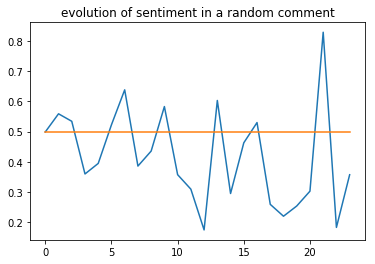

In [653]:
plt.title("evolution of sentiment in a random comment")
plt.plot(sentiment_by_sentence(positives_txt[0], logistic_clf))
plt.plot([.5] * 24)
plt.show()

In [547]:
train_evolution_o = np.array(list(map(lambda c: sentiment_by_sentence(c, logistic_clf), x_train_txt)))

/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [548]:
test_evolution_o = np.array(list(map(lambda c: sentiment_by_sentence(c, logistic_clf), x_test_txt)))

/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [578]:
mean_ln = int(np.array(list(map(len, test_evolution_o))).mean())
mean_ln = 20
int(mean_ln)

20

In [579]:
def resize_vector(vector, new_len):
    return np.kron(np.array([vector.flatten()]), np.array([1] * new_len)).T


In [580]:
train_evolution = np.array(list(map(lambda v: resize_vector(v[0], mean_ln), train_evolution_o)))
test_evolution  = np.array(list(map(lambda v: resize_vector(v[0], mean_ln), test_evolution_o)))

In [581]:
train_evolution = train_evolution.reshape(train_evolution.shape[:-1])
test_evolution  = test_evolution.reshape(test_evolution.shape[:-1])

In [582]:
train_evolution = train_evolution[:, :-1] - train_evolution[:, 1:]
test_evolution  = test_evolution[:, :-1]  - test_evolution[:, 1:]

In [583]:
logistic_evolution_clf = LinearSVC()
logistic_evolution_clf.fit(test_evolution, y_test)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [577]:
(logistic_evolution_clf.predict(train_evolution) == y_train).mean()

0.5

## LDA pre-analysis

In [889]:
lda = MiniBatchSparsePCA(5, n_jobs=-1) #LDA didn't provided good results
lda.fit(list(positives_txt_count.toarray()) + list(negatives_txt_count.toarray()))

MiniBatchSparsePCA(alpha=1, batch_size=3, callback=None, method='lars',
          n_components=5, n_iter=100, n_jobs=-1, random_state=None,
          ridge_alpha=0.01, shuffle=True, verbose=False)

In [891]:
positive_topics = lda.transform(positives_txt_count.toarray())
negative_topics = lda.transform(negatives_txt_count.toarray())
submission_topics = lda.transform(submission_txt_counts.toarray())

In [892]:
shuffle(list(positive_topics))
shuffle(list(negative_topics))

x_train_lda = list(positive_topics[:800]) + list(negative_topics[:800])
x_test_lda  = list(positive_topics[800:]) + list(negative_topics[800:])

training_data_lda = list(zip(x_train_lda, [1] * 800 + [0] * 800))
testing_data_lda  = list(zip(x_test_lda,  [1] * 200 + [0] * 200))

x_train_lda, y_train_lda  = zip(*training_data_lda)
x_test_lda,  y_test_lda   = zip(*testing_data_lda)

In [893]:
logistic_lda_clf = LinearSVC(C=5)
logistic_lda_clf.fit(x_train_lda, y_train_lda)

LinearSVC(C=5, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [894]:
(logistic_lda_clf.predict(x_test_lda) == y_test_lda).mean()

0.575

In [896]:
#vizualize most important words by cluster
for i in range(lda.components_.shape[0]):
    print(list(np.array(count_vect.get_feature_names())[np.array(abs(lda.components_[i]).argsort()[:5])]))

['00', 'pierson', 'piers', 'pierrot', 'pierre']
['00', 'pierced', 'pierce', 'pier', 'piena']
['00', 'piero', 'piering', 'piere', 'piercings']
['00', 'piers', 'pierrot', 'pierre', 'pierpont']
['00', 'piero', 'piering', 'piere', 'piercings']


### Make one classifier by LDA cluster

___TODO ...___

In [920]:
def get_classifier(x_train_lda, cluster_id):
    x_train = np.array(x_train_lda)[np.where(np.array(x_train_lda).argmax(1) == cluster_id)]
    y_train = np.array(y_train_lda)[np.where(np.array(x_train_lda).argmax(1) == cluster_id)]
    clf = LogisticRegression(C=10)
    clf.fit(x_train, y_train)
    return clf

In [921]:
clfs_lda = [get_classifier(x_train_lda, i) for i in range(5)]

In [922]:
preds = np.array([clfs_lda[c].predict([r]) for c, r in zip(np.array(x_test_lda).argmax(1), x_test_lda)]).T[0]

In [923]:
(preds == y_test_lda).mean()

0.5025

## Make Solution

In [228]:
out = map(lambda v: 'M' if v else 'C', logistic_clf.predict(submission_txt_tfidf))

In [229]:
f = open("out_sentiment.txt", 'w')
f.write('\n'.join(out) + '\n')
f.close()

In [194]:
count_vect.get_feature_names()[:100]

['00',
 '000',
 '0000000000001',
 '00001',
 '00015',
 '000s',
 '001',
 '007',
 '0093638',
 '00am',
 '00pm',
 '00s',
 '01',
 '01pm',
 '02',
 '020410',
 '03',
 '04',
 '05',
 '050',
 '06',
 '07',
 '08',
 '089',
 '09',
 '10',
 '100',
 '1000',
 '1000000',
 '1000lb',
 '1000s',
 '1001',
 '1005_note',
 '100b',
 '100k',
 '100m',
 '100min',
 '100mph',
 '100s',
 '100th',
 '100x',
 '100yards',
 '101',
 '101st',
 '102',
 '102nd',
 '103',
 '104',
 '1040',
 '1040a',
 '1040s',
 '105',
 '1050',
 '105lbs',
 '106',
 '106min',
 '107',
 '108',
 '109',
 '10_note',
 '10am',
 '10lines',
 '10mil',
 '10min',
 '10minutes',
 '10p',
 '10pm',
 '10s',
 '10star',
 '10th',
 '10x',
 '10yr',
 '11',
 '110',
 '1100',
 '11001001',
 '1100ad',
 '111',
 '112',
 '1138',
 '114',
 '1146',
 '115',
 '116',
 '117',
 '11_note',
 '11f',
 '11m',
 '11th',
 '12',
 '120',
 '1200',
 '1200f',
 '1201',
 '1202',
 '123',
 '12383499143743701',
 '125',
 '125m',
 '127']